# Описание проекта
Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
Оператор предоставляет два основных типа услуг: 
1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
 - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
 - Выделенная линия технической поддержки (TechSupport);
 - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
 - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Данные состоят из файлов, полученных из разных источников:
 - contract_new.csv — информация о договоре;
 - personal_new.csv — персональные данные клиента;
 - internet_new.csv — информация об интернет-услугах;
 - phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

## Исследовательский анализ данных

In [1]:
#Загрузим необходимые библиотеки
!pip install phik
!pip install imbalanced-learn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import phik
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

import time
from datetime import datetime

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
#Напишем функцию для исследовательского анализа данных в таблицах
def perform_eda(df):
    #подсчитываем количество строк и столбцов
    rows_count, columns_count = df.shape
    print('Количество столбцов:', columns_count)
    print('Количество строк:', rows_count)
    
    #вывод первых нескольких строк таблицы на экран
    print('\nПервые 5 строк данных:')
    display(df.head())
    
    #описание статистики
    print('\nОписание столбцов:')
    display(df.describe())
    
    #описание типов данных и пропущенных значений
    print('\nИнформация о данных:')
    df.info()
    
    #визуализация распределения столбцов
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    if len(numeric_columns) > 0:
        print('\nРаспределение числовых столбцов:')
        df[numeric_columns].hist(bins=30, figsize=(12, 6))
        plt.tight_layout()
        plt.show()
    
    #визуализация корреляционной матрицы
    #correlation_matrix = df.corr()
    #plt.figure(figsize=(10, 8))
    #sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    #plt.title('Корреляционная матрица')
    #plt.show()

In [3]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

Количество столбцов: 8
Количество строк: 7043

Первые 5 строк данных:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Описание столбцов:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Распределение числовых столбцов:


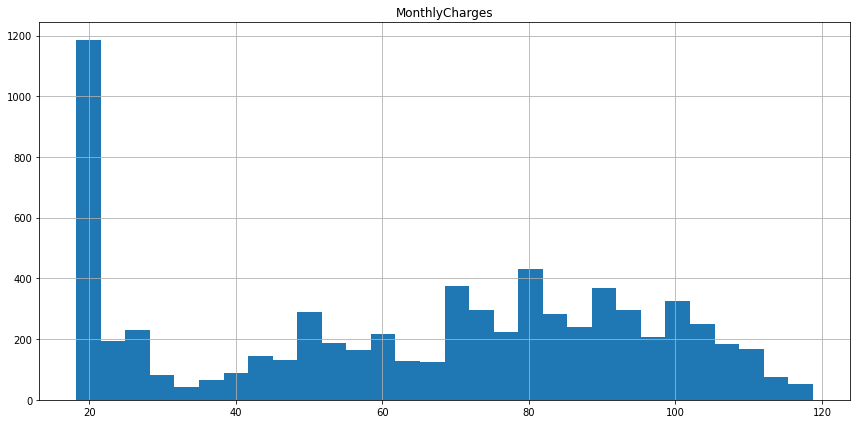

In [4]:
#вызов функции для каждого набора данных
perform_eda(contract)

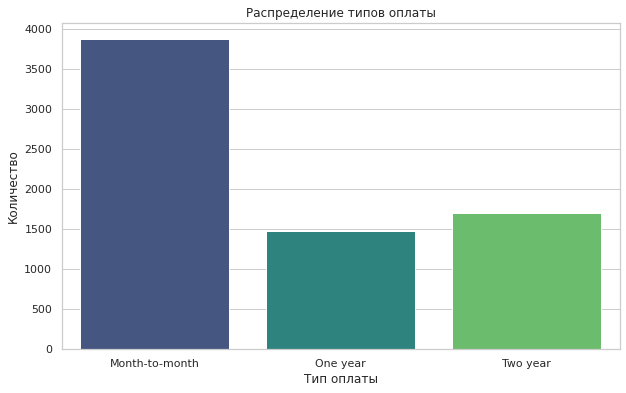

In [5]:
#посмотрим на тип оплаты
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=contract, x='Type', palette='viridis')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество')
plt.title('Распределение типов оплаты')

plt.show()

Видно, что большинство клиентов предпочитают помесячную оплату. Кроме того клиентов, которые готовы заключить контракт два года больше, чем клиентов, которые рассчитывают на год. Возможно, при контракте за два года сразу могут действовать какие-то более лояльные условия. Проверим это:

In [6]:
contract.pivot_table(index='Type', values='MonthlyCharges')

,MonthlyCharges
Type,
Month-to-month,66.398490
One year,65.048608
Two year,60.770413


Действительно, самая низкая цена при заключении контракта сразу на два года. Однако нужно проверить наличие дополнительных услуг или скидок, которые могут влиять на цену.

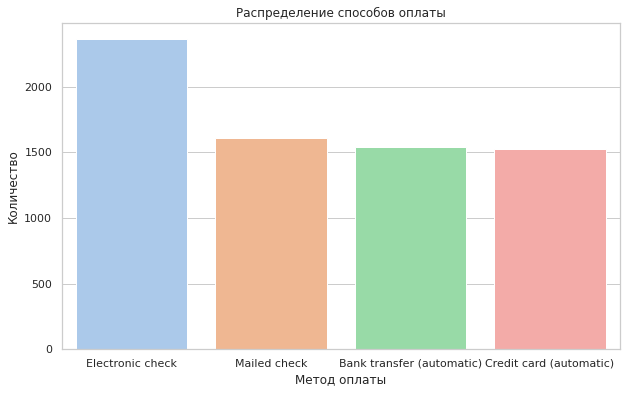

In [7]:
#теперь проверим способ оплаты
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=contract, x='PaymentMethod', palette='pastel')
plt.xlabel('Метод оплаты')
plt.ylabel('Количество')
plt.title('Распределение способов оплаты')

plt.show()

Большинство клиентов предпочитают электронный метод оплаты, видимо, из-за его удобности. Остальные способы оплаты менее распространены и практически одинаковы по объему.

Попробуем более детально посмотреть даты заключения договоров

In [8]:
#Посмотрим, сколько в среднем длится заключение договора
#преобразуем столбцов BeginDate и EndDate в формат даты
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
#contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
contract['EndDate'] = contract['EndDate'].replace('No', pd.NA)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
#фильтруем только завершенные договоры, те, которые еще действуют-оставляем в стороне
completed_contracts = contract[contract['EndDate'] != 'No']
#рассчет разницы между BeginDate и EndDate
completed_contracts['ContractDuration'] = completed_contracts['EndDate'] - completed_contracts['BeginDate']
#преобразовываем в месяцы
completed_contracts['ContractDurationMonths'] = completed_contracts['ContractDuration'].dt.days // 30
#рассчет среднего времени действия договоров в месяцах
average_duration = completed_contracts['ContractDurationMonths'].mean()

print(f"Среднее время действия завершенных договоров: {average_duration:.2f} месяцев")

Среднее время действия завершенных договоров: 30.39 месяцев


In [9]:
#смотрим с какого времени начала заполняться база с договорами
first_contract_date = contract['BeginDate'].min()
print(f"Самая первая дата заключения договора: {first_contract_date}")

Самая первая дата заключения договора: 2013-10-01 00:00:00


In [10]:
#проверим, не совпадает ли дата разрыва договора с датой на конец акутального периода
target_date = '2020-02-01'
filtered_rows = contract[contract['EndDate'] == target_date]
print(filtered_rows)

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges]
Index: []


**Вывод:** Таблица содержит информацию о договорах клиентов оператора связи. Из таблицы видно, что клиенты предпочитают электронный метод оплаты и заключать договор помесячно, даже несмотря на то, что условия (цена) при заключении договора на год и тем более на два года лучше. Средний срок заключения договора составляет 30.39 месяцев (чуть больше двух лет), возможно клиенты заключают договор сразу на два года, пользуются услугами по сниженой цене, но затем продление договора им не интересно (качество услуг не устраивает? помесячная цена выше?). Чаще всего договора заключаются в февраля, расторгаются в ноябре. Данные в датасете имеются начиная с 2013 года.

Для дальнейшей работы с таблицой желательно переименовать столбец customerID в CustomerID. Пропуски не обнаружены. BeginDate и EndDate необходимо перевести в формат datatime (сделано в ходе анализа данных). Столбец TotalCharges необходимо перевести в числовой тип данных. Столбец EndDate указывает на дату окончания договора, но некоторые договоры еще действуют, клиент не разрывал контракт, поэтому некоторые значения в этом столбце равны 'No', на мой взгляд это создает путаницу, поэтому можно заменить 'No' на более понятное значение, например, 'Active'. При анализе распределения столбцов MonthlyCharges имеет выбросы на уровне 20, что выглядит странно и требует дальнейшего изучения. 

Количество столбцов: 5
Количество строк: 7043

Первые 5 строк данных:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Описание столбцов:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Распределение числовых столбцов:


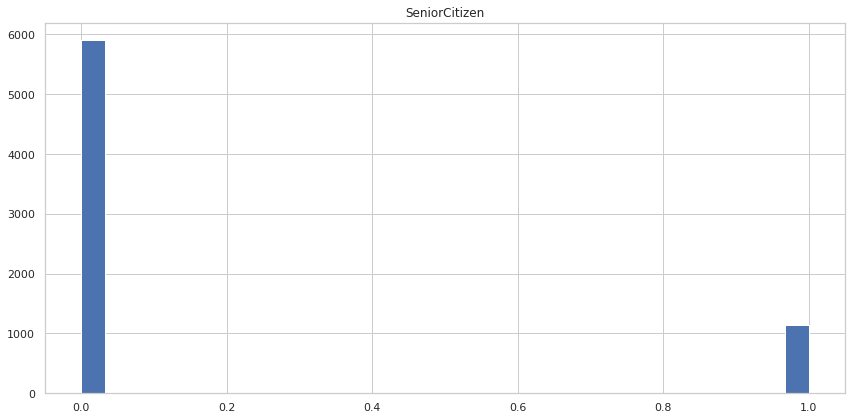

In [11]:
perform_eda(personal)

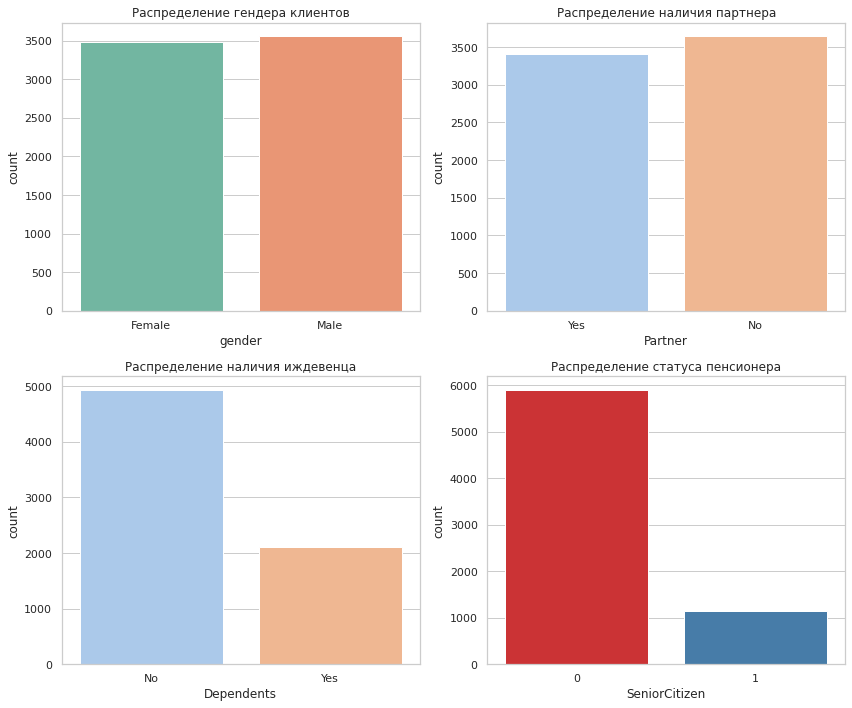

In [12]:
#проверим распределение данных в таблице
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
#график 1 - Гендер клиента
sns.countplot(data=personal, x='gender', palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('Распределение гендера клиентов')
#график 2 - Наличие партнера
sns.countplot(data=personal, x='Partner', palette='pastel', ax=axes[0, 1])
axes[0, 1].set_title('Распределение наличия партнера')
#график 3 - Наличие иждевенца
sns.countplot(data=personal, x='Dependents', palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title('Распределение наличия иждевенца')
#график 4 - Статус пенсионера
sns.countplot(data=personal, x='SeniorCitizen', palette='Set1', ax=axes[1, 1])
axes[1, 1].set_title('Распределение статуса пенсионера')

plt.tight_layout()
plt.show()

Распределение гендера приблизительно одинаковое, у большинства клиентов нет партнера и иждевендца, также большинство клиентов не обладают статусом пенсионера (согласно анализу данных статусом пенсионера обладает только 16% клиентов).

**Вывод:** Таблица содержит информацию о клиентах, включая их пол, статус пенисонера, наличие партнера и наличие иждивенцев. Пропусков не наблюдается. В таблице нужно переименовать столбцы customerID в CustomerID и gender в Gender.

In [13]:
perform_eda(internet)

Количество столбцов: 8
Количество строк: 5517

Первые 5 строк данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Описание столбцов:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Вывод:** Большинство клиентов использует тип интернет-услуги "Fiber optic". Около половины клиентов использует тип интернет-услуги "DSL". Данное распределение может зависеть от потребностей пользователя, доступности услуг в конкретной местности и бюджета. Если клиенту необходимо быстрое и стабильное соединение, то "Fiber optic" может быть предпочтительным вариантом. Если клиенту неободимо решение для повседневных задач, таких как чтение электронной почты, просмотр веб-сайтов и социальных сетей или другие небольшие загрузки, то "DSL" может быть подходящим вариантом. Большинство клиентов (почти 70%) не имеют услуги онлайн-безопасности (OnlineSecurity). Примерно 63% клиентов не подписаны на услугу онлайн-резервного копирования (OnlineBackup). Почти 56% клиентов не имеют услуги защиты устройства (DeviceProtection). Около 63% клиентов не имеют услуги технической поддержки (TechSupport). Большая часть клиентов (порядка 51-52%) не использует услуги стримингового телевидения и стриминговых фильмов.
Что касается самой таблицы, то необходимо переименовать customerID в CustomerID для удобства работы. Пропуски не обнраужены. Также следует отметить, что не на всех пользователей есть инофрмация о дополнительных услугах.

In [14]:
perform_eda(phone)

Количество столбцов: 2
Количество строк: 6361

Первые 5 строк данных:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Описание столбцов:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод** В столбце "MultipleLines" содержится информация о том, подключена ли услуга возможности параллельных линий для телефонной связи.
Самое часто встречающееся значение в столбце "MultipleLines" - "No" (3390 раз), что указывает на то, что большинство клиентов не использует данную услугу. Данные так же не о всех клиентах. Пропусков не обнраужено. Необходимо переименовать customerID в CustomerID.

**ОБЩИЙ ВЫВОД:** Таблица contract содержит информацию о договорах клиентов оператора связи. Клиенты предпочитают электронный метод оплаты и заключать договор помесячно, даже несмотря на то, что условия (цена) при заключении договора на год и тем более на два года лучше. Средний срок заключения договора составляет 30.39 месяцев (чуть больше двух лет), возможно клиенты заключают договор сразу на два года, пользуются услугами по сниженой цене, но затем продление договора им не интересно (качество услуг не устраивает? помесячная цена выше?). Чаще всего договора заключаются в февраля, расторгаются в ноябре. Данные в датасете имеются начиная с 2013 года. Для дальнейшей работы с таблицой желательно переименовать столбец customerID в CustomerID. Пропуски не обнаружены. BeginDate и EndDate необходимо перевести в формат datatime (сделано в ходе анализа данных). Столбец TotalCharges необходимо перевести в числовой тип данных. Столбец EndDate указывает на дату окончания договора, но некоторые договоры еще действуют, клиент не разрывал контракт, поэтому некоторые значения в этом столбце равны 'No', на мой взгляд это создает путаницу, поэтому можно заменить 'No' на более понятное значение, например, 'Active'. При анализе распределения столбцов MonthlyCharges имеет выбросы на уровне 20, что выглядит странно и требует дальнейшего изучения. 

Таблица personal содержит информацию о клиентах, включая их пол, статус пенисонера, наличие партнера и наличие иждивенцев. Пропусков не наблюдается. Распределение гендера приблизительно одинаковое, у большинства клиентов нет партнера и иждевендца, также большинство клиентов не обладают статусом пенсионера (согласно анализу данных статусом пенсионера обладает только 16% клиентов). В таблице нужно переименовать столбцы customerID в CustomerID и gender в Gender для более удобной работы. 

Из таблицы internet было определено, что большинство клиентов использует тип интернет-услуги "Fiber optic". Чуть меньше половины клиентов использует тип интернет-услуги "DSL". Данное распределение может зависеть от потребностей пользователя, доступности услуг в конкретной местности и бюджета. Если клиенту необходимо быстрое и стабильное соединение, то "Fiber optic" может быть предпочтительным вариантом. Если клиенту неободимо решение для повседневных задач, таких как чтение электронной почты, просмотр веб-сайтов и социальных сетей или другие небольшие загрузки, то "DSL" может быть подходящим вариантом. Большинство клиентов (почти 70%) не имеют услуги онлайн-безопасности (OnlineSecurity). Примерно 63% клиентов не подписаны на услугу онлайн-резервного копирования (OnlineBackup). Почти 56% клиентов не имеют услуги защиты устройства (DeviceProtection). Около 63% клиентов не имеют услуги технической поддержки (TechSupport). Большая часть клиентов (порядка 51-52%) не использует услуги стримингового телевидения и стриминговых фильмов. Что касается самой таблицы, то необходимо переименовать customerID в CustomerID для удобства работы. Пропуски не обнраужены. Также следует отметить, что не на всех пользователей есть инофрмация о дополнительных услугах.

В таблице phone содержится информация о том, подключена ли услуга возможности параллельных линий во время звонка. Большинство клиентов не использует данную услугу, однако данные так же не о всех клиентах. Пропусков не обнраужено. Необходимо переименовать customerID в CustomerID.

# Примерный план решения задачи:

Подготовка данных:
- Изменить имена столбцов, где это необходимо.
- Преобразовать столбцы в необходимые форматы.

Исследовательский анализ:
- Анализ распределения числовых признаков с помощью гистограмм.
- Визуализация категориальных признаков с помощью столбчатых диаграмм.
- Построение корреляционной матрицы для определения зависимостей между числовыми признаками.

Прогнозирование оттока клиентов:
- Создание целевой переменной, которая будет обозначать отток клиента.
- Преобразование категориальных признаков в числовые с помощью One-Hot Encoding.
- Разделение данных на обучающую и тестовую выборки.
- Обучение модели машинного обучения для прогнозирования оттока клиентов.

Оценка производительности модели с использованием метрик.

**Цель проекта** заключается в разработке модели машинного обучения, которая должна быть способна прогнозировать отток клиентов оператора связи. Это позволит оператору предпринимать меры для удержания клиентов и повышения их удовлетворенности путем предложения специальных условий.

# Анализ данных и подготовка признаков

В соответствии с исследовательским анализом данных для дальнейшей работы нужно произвести следующие изменения:
 - Таблица contract: переименовать столбец customerID в CustomerID. Столбец TotalCharges перевести в числовой тип данных. Изменить в столбцу EndDate значения 'No' на дату 1 февраля 2020 (что означает, что договор действует на конец акутального периода) и перевести столбец в формат даты. Изначально планировалось переделать значения 'No' на значения 'Active', но вследствии необходимости формата даты эту часть опускаем.
 - Таблица personal: переименовать столбцы customerID в CustomerID и gender в Gender.
 - Таблицы internet: переименовать customerID в CustomerID для удобства работы.
 - Таблица phone: переименовать customerID в CustomerID.

In [15]:
#таблица contract
contract.rename(columns={'customerID': 'CustomerID'}, inplace=True)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

today_date = datetime(2020, 2, 1)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
contract['EndDate'] = contract['EndDate'].fillna(today_date)
#таблица personal
personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'}, inplace=True)
#таблица internet
internet.rename(columns={'customerID': 'CustomerID'}, inplace=True)
#таблица phone
phone.rename(columns={'customerID': 'CustomerID'}, inplace=True)

In [16]:
contract.head(10)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [17]:
contract.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [18]:
#Сводим таблицы в один датасет по столбцу CustomerID.
merged_data = contract.merge(personal, on='CustomerID', how='left')
merged_data = merged_data.merge(internet, on='CustomerID', how='left')
merged_data = merged_data.merge(phone, on='CustomerID', how='left')

In [19]:
merged_data.head(10)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


При объединении в столбцах с дополнительными услугами (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines) появились пропуски. По видимому они означают, что клиенты данными услугами не пользуются, поэтому заменим пропуски на 'No'. Заменять пропуски будем в копии объединенной таблицы, чтобы сохранить данные.

In [20]:
customer_lost = merged_data.copy()

In [21]:
columns_to_fill = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
customer_lost[columns_to_fill] = customer_lost[columns_to_fill].fillna('No')
missing_values_count = customer_lost.isna().sum()
print(missing_values_count)

CustomerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MultipleLines        0
dtype: int64


Также появились пропуски в TotalCharges. Сделаем фильтрацию, чтобы посмотреть на строки с пропущенными значениями.

In [22]:
missing_total_charges = customer_lost[customer_lost['TotalCharges'].isna()]
print(missing_total_charges)

      CustomerID  BeginDate    EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year               No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Gender  \
488   Bank transfer (automatic)           52.55           NaN  Female   
753                Mailed

Всех этих клиентов объединяет то, что договор заключен на момент 1 февраля 2020 года, то есть клиенты новые, только что вошедшие в компанию. Будем заменять пропущенные значения на 0, поскольку у данных клиентов еще не было фактической оплаты.

In [23]:
customer_lost['TotalCharges'] = customer_lost['TotalCharges'].fillna(0)
missing_values_count = customer_lost.isna().sum()
print(missing_values_count)

CustomerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


In [24]:
#добавим новый признак в таблицу, количество дней, на сколько дней был заключен договор
customer_lost['ContractDurationDays'] = (customer_lost['EndDate'] - customer_lost['BeginDate']).dt.days
#print(customer_lost[['CustomerID', 'ContractDurationDays']].head())
customer_lost.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDurationDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


In [25]:
#проверим не дублируются ли клиенты в таблице
duplicates_count = customer_lost.duplicated().sum()
if duplicates_count == 0:
    print("В таблице нет дубликатов.")
else:
    print(f"В таблице есть {duplicates_count} дубликатов.")

В таблице нет дубликатов.


Наш целевой признак - это столбец EndDate. Если договор прекращен, значит клиент покинул компанию. Будем добавлять этот признак в таблицу  customer_lost под именем CustomerLost, чтобы обозначить потерю клиента. 0-клиент остался, 1-клиент разорвал договор.

In [26]:
customer_lost['CustomerLost'] = np.where(customer_lost['EndDate'] == '2020-02-01', 0, 1)
#customer_lost.head(10)

Посмотрим еще раз на распределение данных в сводной таблице. Для визуализации числовых признаков будем использовать гистограммы и ящики с усами. Для визуализации категорий будем использовать count plot. Несмотря на то, что категории уже были визуализированы в исследовательской части данных, сделаем это еще раз, чтобы убедиться в достоверности информации после обработки полученных данных.

In [27]:
def plot_numerical_features(data, numerical_columns):
    for column_name in numerical_columns:
        plt.figure(figsize=(12, 5))
        
        #функция для гистограммы
        plt.subplot(1, 2, 1)
        plt.hist(data[column_name], bins=30, color='blue', alpha=0.7)
        plt.xlabel(column_name)
        plt.ylabel('Частота')
        plt.title(f'Распределение {column_name}')
        #функция для ящика
        plt.subplot(1, 2, 2)
        sns.boxplot(data=data, x=column_name, color='green')
        plt.xlabel(column_name)
        plt.title(f'Ящик с усами для {column_name}')
        plt.tight_layout()
        plt.show()

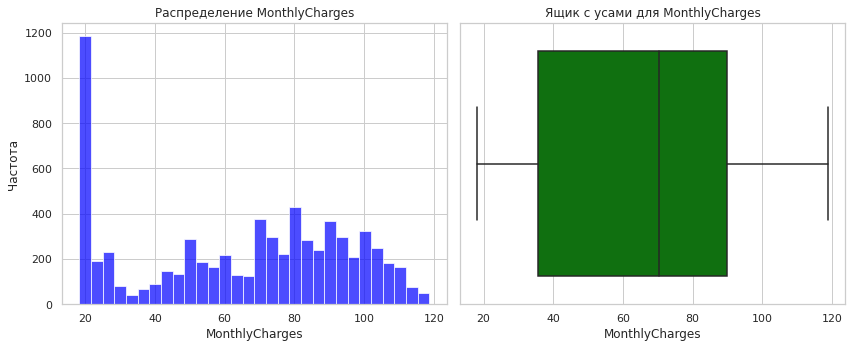

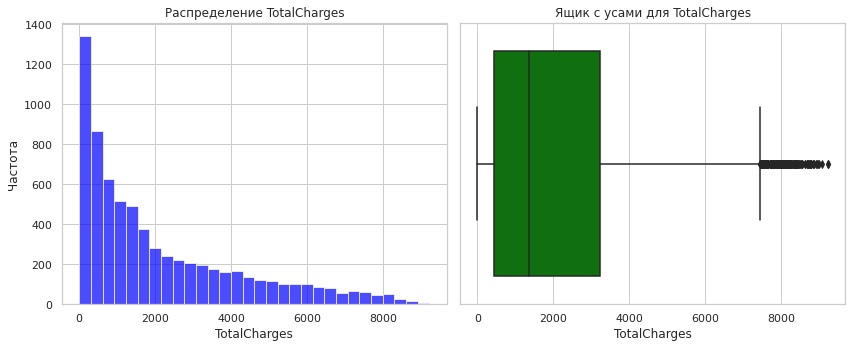

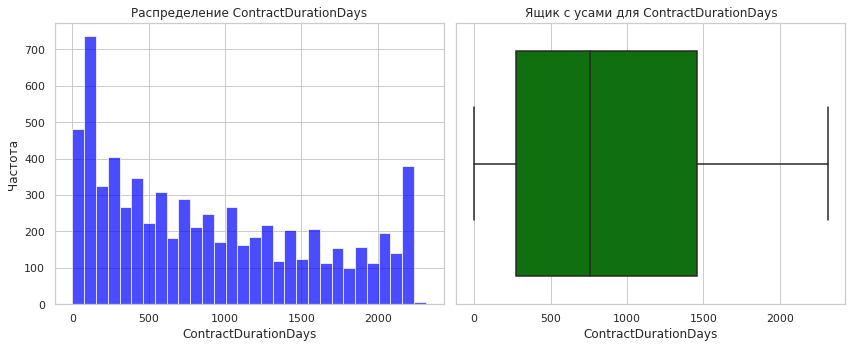

In [28]:
numerical_columns = ['MonthlyCharges', 'TotalCharges', 'ContractDurationDays']
plot_numerical_features(customer_lost, numerical_columns)

In [29]:
#stats = customer_lost['MonthlyCharges'].describe()

#median = stats['50%']
#q1 = stats['25%']
#q3 = stats['75%']
#print(f"Медиана: {median:.2f}")
#print(f"25-й процентиль: {q1:.2f}")
#print(f"75-й процентиль: {q3:.2f}")

На уровне 20 в столбце MonthlyCharges есть пик. Также есть небольшой пик на уровне 80. Выбросов нет. Медиана - 70.35, нижний квартиль - 35.5, верхний квартиль - 89.8. Выбросы отсутствуют.

Значения в столбце TotalCharges убывают. Много значений на уровне нуля, возможно это новые клиенты, с нулевым общим платежем, а также клиенты, которые совсем недавно пришли в компанию. Медиана 1343.3, нижний квартиль 436.7, верхний квартиль - 3236.6. Есть выбросы после 6000.

Есть два пика в столбце ContractDurationDays - в районе низких значений в начале графика, и в районе высоких значений, что характеризует новых клиентов, которые недавно в компании и клиентов, которые в компании достаточно давно. Медиана 761, нижний квартиль 276, верхний квартиль - 1461. Выбросы отсутствуют.

In [30]:
#удалим выбросы из столбца TotalCharges
initial_rows = len(customer_lost)
customer_lost = customer_lost[customer_lost['TotalCharges'] <= 6000]
remaining_rows = len(customer_lost)
deleted_rows = initial_rows - remaining_rows
print(f"Удалено {deleted_rows} строк.")

Удалено 544 строк.


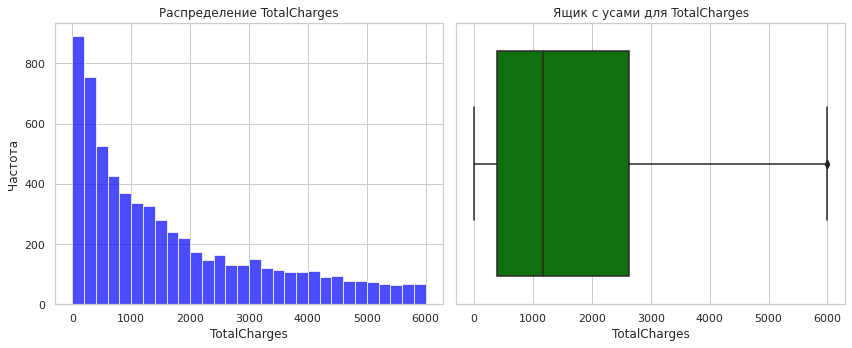

In [31]:
numerical_columns = ['TotalCharges',]
plot_numerical_features(customer_lost, numerical_columns)

Теперь график выглядит лучше, выбросы удалены

In [32]:
#Посмотрим также на корреляцию признаков, чтобы дать более развернутый ответ
subset = customer_lost[['MonthlyCharges', 'TotalCharges', 'ContractDurationDays']]
correlation_matrix = subset.corr()
print(correlation_matrix)

                      MonthlyCharges  TotalCharges  ContractDurationDays
MonthlyCharges              1.000000      0.559468              0.051924
TotalCharges                0.559468      1.000000              0.770563
ContractDurationDays        0.051924      0.770563              1.000000


Между 'MonthlyCharges' и 'TotalCharges' есть заметная положительная корреляция с коэффициентом корреляции около 0.55. Это вполне логично, так как общие платежи накапливаются со временем на основе ежемесячных платежей.
Есть сильная положительная корреляция между 'TotalCharges' и 'ContractDurationDays' с коэффициентом корреляции около 0.77. Здесь также никакой новой информации, чем дольше клиент остается с компанией и продолжает платить, тем больше его общие платежи.
Слабая положительная корреляция между 'MonthlyCharges' и 'ContractDurationDays' с коэффициентом корреляции около 0.05 указывает на то, что срок действия договора не сильно зависит от ежемесячных платежей, очевидно, что на него влияют другие факторы.

In [33]:
#Перед визуализацией и дальнейшим поиском корреляцию переведем колонку SeniorCitizen в логический, чтобы анализировать его как категориальный признак
customer_lost['SeniorCitizen'] = customer_lost['SeniorCitizen'].astype(bool)

In [34]:
#визуализируем также категории
def plot_countplots(data, categorical_columns):
    num_columns = len(categorical_columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 5 * num_columns))
    for i, column in enumerate(categorical_columns):
        sns.countplot(data=data, x=column, ax=axes[i])
        axes[i].set_title(f'Count Plot of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

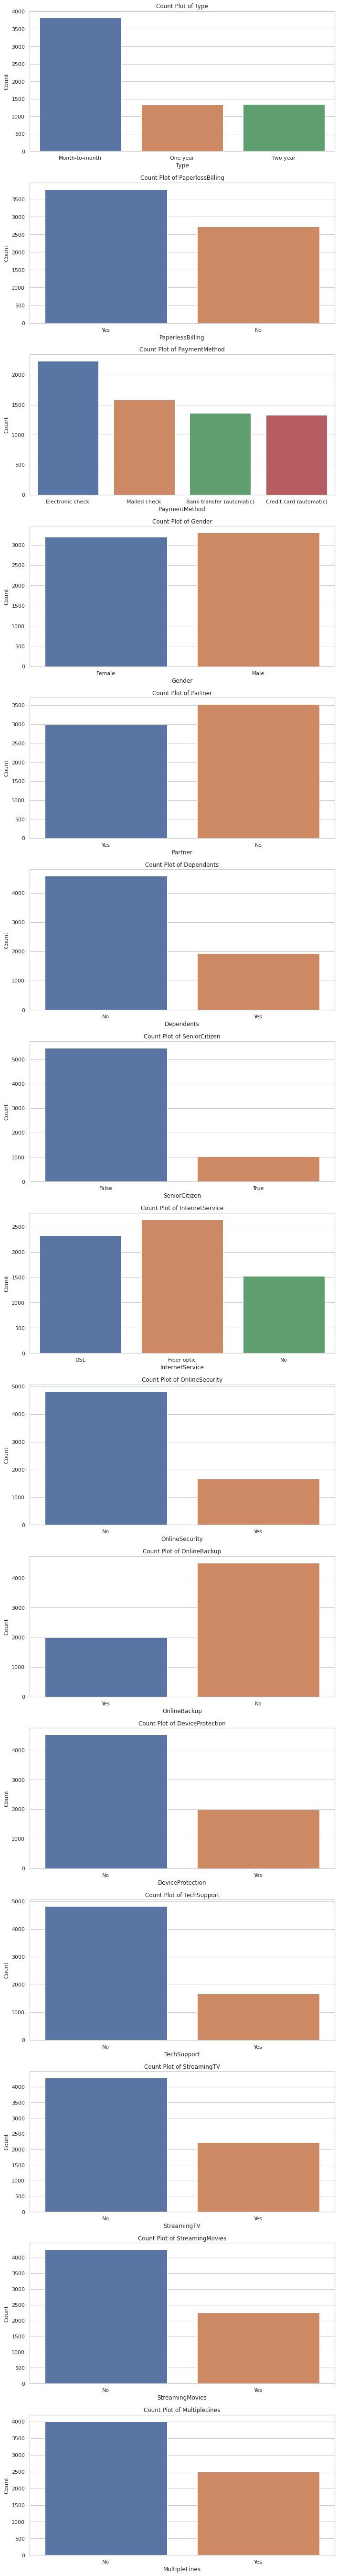

In [35]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'Partner', 'Dependents', 'SeniorCitizen',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

plot_countplots(customer_lost, categorical_features)

Особых изменений не обнаружено. Типичный клиент: контракт заключается помесячно,предпочитает получать электронный платежный документ, делает оплату через интернет,без партнера, без инждевендцев, не относится к пенсионерам, предпочитает подключение через оптоволокно,какими-либо дополнительными услугами не пользуется.

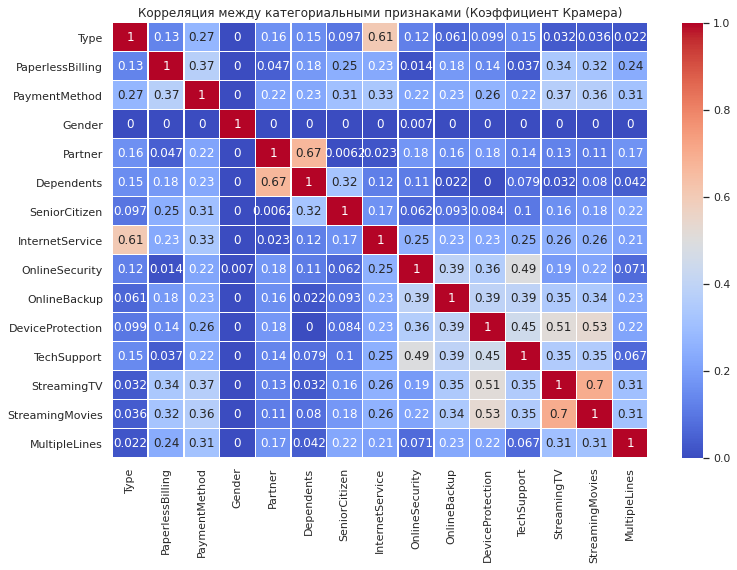

In [36]:
#посмотрим на корреляцию признаков между собой
categorical_correlations = customer_lost[categorical_features].phik_matrix()

plt.figure(figsize=(12, 8))
sns.heatmap(categorical_correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляция между категориальными признаками (Коэффициент Крамера)')
plt.show()

Partner  и Dependents имеют положительную корреляцию, что может означать, что клиенты с партнерами чаще имеют иждивенцев. Это логично, поскольку когда у клиента есть партнер, увеличивается появление иждевендцев (например, дети).
StreamingTV и StreamingMovies имеют сильную положительную корреляцию, поскольку это взаимодополняющие друг друга услуги.
Также и признаки OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies имеют внутренние корреляции между собой, что указывает на взаимосвязь между услугами.
InternetService имеет сильную корреляцию с Type. Выбор типа интернета зависит от типа договора.
PaperlessBilling имеет довольно сильную положительную корреляцию с PaymentMethod, StreamingMovies  и StreamingTV. Это может указывать на то, что клиенты, использующие электронное выставление счетов, чаще используют определенные способы оплаты, а также подключены к стриминговому телевидению.
MultipleLines имеет некоторую корреляцию с дополнительными услугами. Возможно, что категория клиентов, которые используют несколько линий, также согласны и на подключение дополнительных услуг (возможно, категория клиентов с более высоким доходом).
SeniorCitizen имеют положительную корреляцию с Dependents, старшие граждане будут иметь больше вероятность иметь иждивенцев?

Теперь посмотрим на корреляцию признаков с нашим целевым признаком.

In [37]:
#корреляция между числовыми признаками
numeric_features = ['MonthlyCharges', 'TotalCharges', 'ContractDurationDays']

correlation_with_target = {}
for feature in numeric_features:
    corr, _ = pointbiserialr(customer_lost['CustomerLost'], customer_lost[feature])
    correlation_with_target[feature] = corr

print(correlation_with_target)

{'MonthlyCharges': 0.2049958843542268, 'TotalCharges': 0.16752983817652786, 'ContractDurationDays': 0.07679256169219924}


Видим положительную корреляцию MonthlyCharges с CustomerLost, с увеличением ежемесячных платежей вероятность потери клиента увеличивается. Возможно, что более дорогие услуги могут быть менее привлекательными для клиентов, что может увеличить вероятность их ухода.
TotalCharges также имеет положительную корреляцию с CustomerLost, но значение корреляции ниже, чем у MonthlyCharges, то есть общие затраты клиента не так сильно влияют на вероятность ухода клиента, как увеличение ежемесячных платежей.
ContractDurationDays имеет наименьшую корреляцию с CustomerLost. Это может означать, что продолжительность контракта практически не влияет на вероятность ухода клиента.
Значения корреляции не высокие, поэтому эти признаки скорее всего не будут играть решающую роль в предсказании ухода клиентов. Однако, следует отметить, что значения корреляции настолько не существенные, что их можно не рассматривать.

In [38]:
#корреляция между категориям
for cat_feature in categorical_features:
    crosstab = pd.crosstab(customer_lost[cat_feature], customer_lost['CustomerLost'])
    chi2, p, _, _ = chi2_contingency(crosstab)
    print(f'Chi-Square test for {cat_feature}: p-value = {p}')

Chi-Square test for Type: p-value = 6.344461634686161e-56
Chi-Square test for PaperlessBilling: p-value = 2.683593755754556e-07
Chi-Square test for PaymentMethod: p-value = 1.0491488798733019e-38
Chi-Square test for Gender: p-value = 0.25878713064149084
Chi-Square test for Partner: p-value = 7.735446475441439e-44
Chi-Square test for Dependents: p-value = 0.0017956179457946266
Chi-Square test for SeniorCitizen: p-value = 8.006712157229608e-07
Chi-Square test for InternetService: p-value = 6.833286013067012e-22
Chi-Square test for OnlineSecurity: p-value = 4.352789214288141e-20
Chi-Square test for OnlineBackup: p-value = 1.1995888280503383e-52
Chi-Square test for DeviceProtection: p-value = 9.633588570900178e-49
Chi-Square test for TechSupport: p-value = 7.948128237215079e-15
Chi-Square test for StreamingTV: p-value = 2.257372663032051e-42
Chi-Square test for StreamingMovies: p-value = 3.1020119117104346e-50
Chi-Square test for MultipleLines: p-value = 1.094148431305115e-62


Смотрим взаимосвязь между признаками по P-значению, насколько сильно данные противоречат нулевой гипотезе. Наша нулевая гипотеза "нет связи между данным категориальным признаком и вероятностью ухода клиента". Исходят из этого, Gender и Dependents практически не влияют на уход клиента из компании. Остальные признаки влияют на уходи клиента из компании, в частности MultipleLines, OnlineBackup, DeviceProtection, PaymentMethod, StreamingMovies.

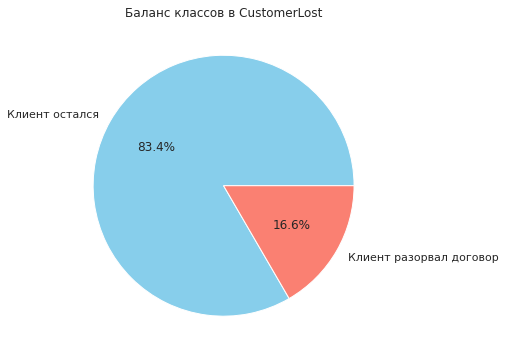

In [39]:
#поверим дисбаланс классов в целевой переменной
plt.figure(figsize=(6, 6))
class_counts = customer_lost['CustomerLost'].value_counts()
plt.pie(class_counts, labels=['Клиент остался', 'Клиент разорвал договор'], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Баланс классов в CustomerLost')
plt.show()

Значительное количество клиентов все еще остаются в компании.

**Вывод:** Были сделаны следующие изменения: Таблица contract: переименован столбец customerID в CustomerID. Столбец TotalCharges переведен в числовой тип данных. Изменены в столбцу EndDate значения 'No' на дату 1 февраля 2020 (что означает, что договор действует на конец акутального периода) и формат изменен на дату. Таблица personal: переименованы столбцы customerID в CustomerID и gender в Gender. Таблица internet: переименован customerID в CustomerID. Таблица phone: переименован customerID в CustomerID. Все таблицы были сведены в одну по столбцу CustomerID, создана копия таблицы для работы. При объединении в столбцах с дополнительными услугами (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines) появились пропуски, которые были заменены на 'No', поскольку они означали, что клиенты данными услугами не пользуются.  Пропуски в TotalCharges были заменены на 0, поскольку речь шла о новых клиентах, которые только заключили договор и общих платежей у них еще не было. Был добавлен новый признак ContractDurationDays который характеризует на сколько дней был заключен договор. Данные в сводной таблицы были проверены на дубликаты, их обнаружено не было. 

Определен целевой признак- это столбец EndDate. Если договор прекращен, значит клиент покинул компанию. Добавили этот признак в таблицу под именем CustomerLost, чтобы обозначить потерю клиента. 0-клиент остался, 1-клиент разорвал договор.

Было еще раз проверено распределение в таблице, после обработки данных. На уровне 20 в столбце MonthlyCharges есть пик. Также есть небольшой пик на уровне 80. Выбросов нет. Медиана - 70.35, нижний квартиль - 35.5, верхний квартиль - 89.8. Выбросы отсутствуют. Значения в столбце TotalCharges убывают. Много значений на уровне нуля, возможно это новые клиенты, с нулевым общим платежем, а также клиенты, которые совсем недавно пришли в компанию. Медиана 1343.3, нижний квартиль 436.7, верхний квартиль - 3236.6. Есть выбросы после 7500. Данные выбросы были удалены из датафрейма. Есть два пика в столбце ContractDurationDays - в районе низких значений в начале графика, и в районе высоких значений, что характеризует новых клиентов, которые недавно в компании и клиентов, которые в компании достаточно давно. Медиана 761, нижний квартиль 276, верхний квартиль - 1461. Выбросы отсутствуют. Типичный клиент: контракт заключается помесячно,предпочитает получать электронный платежный документ, делает оплату через интернет,без партнера, без инждевендцев, не относится к пенсионерам, предпочитает подключение через оптоволокно,какими-либо дополнительными услугами не пользуется.

Была проверена корреляция между признаками. Partner и Dependents имеют положительную корреляцию, что может означать, что клиенты с партнерами чаще имеют иждивенцев. Это логично, поскольку когда у клиента есть партнер, увеличивается появление иждевендцев (например, дети). StreamingTV и StreamingMovies имеют сильную положительную корреляцию, поскольку это взаимодополняющие друг друга услуги. Также и признаки OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies имеют внутренние корреляции между собой, что указывает на взаимосвязь между услугами. InternetService имеет сильную корреляцию с Type. Выбор типа интернета зависит от типа договора. PaperlessBilling имеет довольно сильную положительную корреляцию с PaymentMethod, StreamingMovies и StreamingTV. Это может указывать на то, что клиенты, использующие электронное выставление счетов, чаще используют определенные способы оплаты, а также подключены к стриминговому телевидению. MultipleLines имеет некоторую корреляцию с дополнительными услугами. Возможно, что категория клиентов, которые используют несколько линий, также согласны и на подключение дополнительных услуг (возможно, категория клиентов с более высоким доходом). SeniorCitizen имеют положительную корреляцию с Dependents, старшие граждане будут иметь больше вероятность иметь иждивенцев?

Была проверена корреялция между признаками и уелевой переменной. Видим положительную корреляцию MonthlyCharges с CustomerLost, с увеличением ежемесячных платежей вероятность потери клиента увеличивается. Возможно, что более дорогие услуги могут быть менее привлекательными для клиентов, что может увеличить вероятность их ухода.
TotalCharges также имеет положительную корреляцию с CustomerLost, но значение корреляции ниже, чем у MonthlyCharges, то есть общие затраты клиента не так сильно влияют на вероятность ухода клиента, как увеличение ежемесячных платежей.
ContractDurationDays имеет наименьшую корреляцию с CustomerLost. Это может означать, что продолжительность контракта практически не влияет на вероятность ухода клиента. Значения корреляции не слишком высокие, поэтому эти признаки скорее всего не будут играть решающую роль в предсказании ухода клиентов. Корреляция между категориями и целевой переменной была проверена с помощью P-значения, насколько сильно данные противоречат нулевой гипотезе. Наша нулевая гипотеза "нет связи между данным категориальным признаком и вероятностью ухода клиента". Исходят из этого, Gender и Dependents практически не влияют на уход клиента из компании. Остальные признаки влияют на уход клиента из компании, в частности MultipleLines, OnlineBackup, DeviceProtection, PaymentMethod, StreamingMovies. Таким образом, если клиент не будет подписан на дополнительные услуги, то он может уйти из компании с большой долей вероятности.

Целевая переменная проверена на баланс классов. Значительное количество клиентов все еще остаются в компании.

# Построение модели

In [40]:
pd.set_option('display.max_columns', None)
print(customer_lost.head())

   CustomerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  Gender  \
0           Electronic check           29.85         31.04  Female   
1               Mailed check           56.95       2071.84    Male   
2               Mailed check           53.85        226.17    Male   
3  Bank transfer (automatic)           42.30       1960.60    Male   
4           Electronic check           70.70        353.50  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0          False     Yes         No             DSL             No   
1     

In [41]:
#Удалим столбцы BeginDate и EndDate, поскольку у нас помиомо них есть столбец с количеством дней договора (ContractDurationDays)
customer_lost = customer_lost.drop(['BeginDate', 'EndDate'], axis=1)
customer_lost.head()

,CustomerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDurationDays,CustomerLost
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No,123,0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No,153,0


In [42]:
#определяем целевой показатель
y = customer_lost['CustomerLost']
#определяем признаки
X = customer_lost.drop(columns=['CustomerLost'])

In [43]:
#разделяем данные на тренировочный и тестовый наборы, 75% для тренировки и 25% для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=280823)

In [44]:
print("Длина тренировочного набора данных (X_train):", len(X_train))
print("Длина тренировочного набора меток (y_train):", len(y_train))

print("Длина тестового набора данных (X_test):", len(X_test))
print("Длина тестового набора меток (y_test):", len(y_test))

Длина тренировочного набора данных (X_train): 4874
Длина тренировочного набора меток (y_train): 4874
Длина тестового набора данных (X_test): 1625
Длина тестового набора меток (y_test): 1625


**Вывод:** Из датасета были удалены столбцы BeginDate и EndDate. Были определены целевой показатель и признаки. Данные были разделены на тренировочный и тестовый наборы, в соотношении 75% и 25%. Длина тренировочного набора данных (X_train): 5136. Длина тренировочного набора меток (y_train): 5136. Длина тестового набора данных (X_test): 1712. Длина тестового набора меток (y_test): 1712.

# Обучение моделей

Наша задача относится к бинарной классификации и предполагает разделение объектов на два класса: положительный и отрицательный (или 1 и 0). Поэтому в качестве модели мы возьмем случайный лес, catboost, и градиентный бустинг.

In [45]:
#список признаков
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'Partner', 'Dependents', 'SeniorCitizen',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
numeric_features = ['MonthlyCharges', 'TotalCharges', 'ContractDurationDays']
#создаем трансформаторов
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#объединяем трансформаторов в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#создаем пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

In [46]:
#проверим правильность кодировки
pipeline.fit(X_train, y_train)
transformed_data = pipeline.transform(X_train)
#получение имен
categorical_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features)
#числовых и категориальные признаки-объединение
feature_names = numeric_features + list(categorical_feature_names)
#создаем датафрейм
transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
print(transformed_df.head())

   MonthlyCharges  TotalCharges  ContractDurationDays  Type_Month-to-month  \
0       -1.437490     -0.273005              1.759021                  0.0   
1        1.131067      1.487266              0.822512                  1.0   
2       -1.427168     -0.988123             -1.001899                  1.0   
3       -1.428888     -0.360393              1.266463                  0.0   
4       -1.397921     -0.119144              2.249960                  0.0   

   Type_One year  Type_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
0            0.0            1.0                  1.0                   0.0   
1            0.0            0.0                  0.0                   1.0   
2            0.0            0.0                  1.0                   0.0   
3            0.0            1.0                  1.0                   0.0   
4            0.0            1.0                  1.0                   0.0   

   PaymentMethod_Bank transfer (automatic)  \
0               

## Случайный лес

In [47]:
random_forest = RandomForestClassifier(random_state=280823)

#создаем пайплайн
full_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', random_forest)  # Добавляем модель RandomForestClassifier
])

#параметры модели
param_grid_rf = {
    'model__n_estimators': [10, 50, 100, 200], 
    'model__max_depth': [None, 5, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4, 10]
}

#GridSearchCV и ROC-AUC 
grid_search_rf = GridSearchCV(
    full_pipeline_rf,  #пайплан
    param_grid=param_grid_rf,
    cv=5,  #кросс валидация
    scoring=make_scorer(roc_auc_score, greater_is_better=True), #ROC-AUC
    verbose=1,
    n_jobs=-1,
)
grid_search_rf.fit(X_train, y_train)
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best ROC-AUC Score на тренировочной выборке: ", grid_search_rf.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters:  {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 10}
Best ROC-AUC Score на тренировочной выборке:  0.6113197112585865


## Градиентный бустинг

In [48]:
gradient_boosting = GradientBoostingClassifier(random_state=280823)

#пайплайн
full_pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', gradient_boosting)
])

#параметры
param_grid_gb = {
    'model__n_estimators': [50, 100, 200, 300], 
    'model__learning_rate': [0.01, 0.1, 0.2], 
    'model__max_depth': [3, 4, 5], 
    'model__subsample': [0.5, 0.8, 0.9]
}

grid_search_gb = GridSearchCV(
    full_pipeline_gb, 
    param_grid=param_grid_gb,
    cv=5, 
    scoring=make_scorer(roc_auc_score, greater_is_better=True), 
    verbose=1,  
    n_jobs=-1,
) 

grid_search_gb.fit(X_train, y_train)
print("Best Parameters: ", grid_search_gb.best_params_)
print("Best ROC-AUC Score на тренировочной выборке: ", grid_search_gb.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:  {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.9}
Best ROC-AUC Score на тренировочной выборке:  0.7286588241967215


## CatBoostClassifier

In [49]:
catboost_classifier = CatBoostClassifier(random_state=280823, verbose=0)

full_pipeline_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', catboost_classifier) 
])
#параметры
param_grid_catboost = {
    'model__n_estimators': [50, 100, 200],  
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__max_depth': [3, 4, 5, 7], 
    'model__subsample': [0.8, 0.9, 1.0]
}

grid_search_catboost = GridSearchCV(
    full_pipeline_catboost,
    param_grid=param_grid_catboost,
    cv=5,  
    scoring=make_scorer(roc_auc_score, greater_is_better=True), 
    verbose=1,
    n_jobs=-1,
)

grid_search_catboost.fit(X_train, y_train)
print("Best Parameters for CatBoost: ", grid_search_catboost.best_params_)
print("Best ROC-AUC Score for CatBoost on the training set: ", grid_search_catboost.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters for CatBoost:  {'model__learning_rate': 0.3, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best ROC-AUC Score for CatBoost on the training set:  0.747768836705267


По результатам ROC-AUC выбираем CatBoost, который показал лучший результат - 0.74.

In [50]:
best_catboost_pipeline = grid_search_catboost.best_estimator_
y_pred_proba = best_catboost_pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC на тестовых данных:", roc_auc)

ROC-AUC на тестовых данных: 0.9115421383647798


На тестовых данных получено значение ROC-AUC 0.91.

Получаем важность признаков.

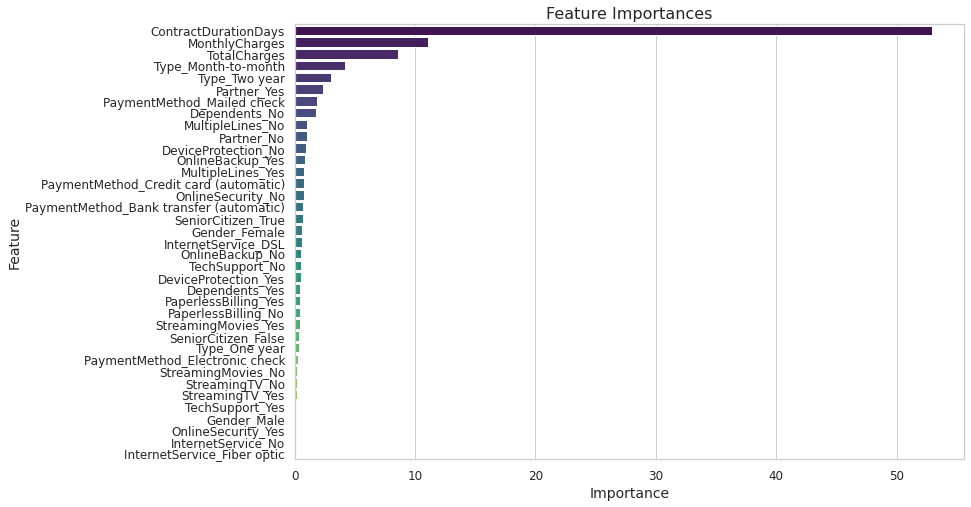

In [51]:
#получение лучшей модели
best_catboost_model = grid_search_catboost.best_estimator_.named_steps['model']
#получение важности признаков
feature_importances = best_catboost_model.feature_importances_
#названия столбцов
feature_names = transformed_df.columns  # Используйте имена столбцов из вашего преобразованного DataFrame
#вносим в датафрейм для составления графика
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
#сортируем
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Самые важные факторы-это сколько клиент является клиентом компании, сколько он платит в месяц и тип контракта.

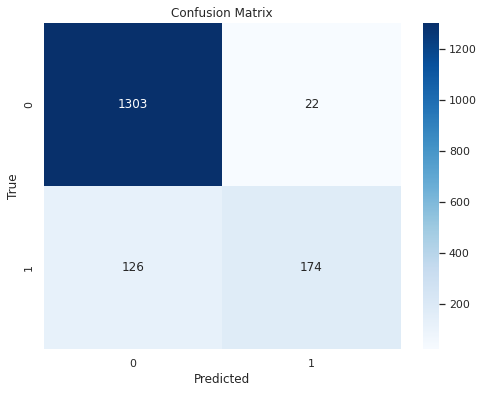

In [52]:
#получение лучшей модели
best_catboost_pipeline.fit(X_train, y_train)
#получение предсказаний
y_pred = best_catboost_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Модель допускает относительно небольшое количество ложных положительных (22), что может быть хорошим признаком, но также присутствует и более высокое значение ложных отрицательных ответов (126). Модель правильно классифицирует большинство клиентов, которые остались (1303), и модель правильно классифицирует некоторых клиентов, которые ушли (174).

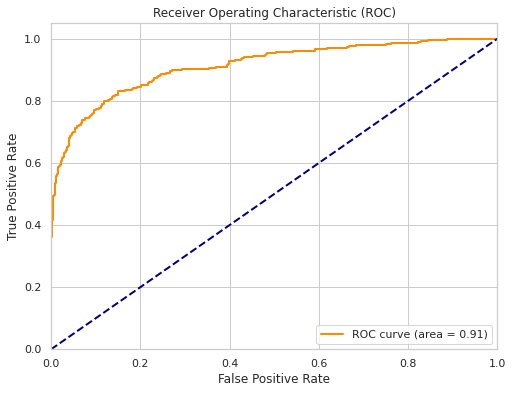

In [53]:
#Далее, строим ROC-кривую и добавляем AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

Метрика ROC-AUC - 0.91, чем ближе к 1, тем лучше результат.

**Вывод:** Наша задача относится к бинарной классификации и предполагает разделение объектов на два класса: положительный и отрицательный (или 1 и 0). Поэтому в качестве модели были взяты случайный лес, catboost, и градиентный бустинг. Был создан пайплайн для предобработки данных, который включал кодирование и масштабирование признаков. Была проверенна правильность кодировки. Далее пайплайн был использован для построения трех моделей. В качестве метрики была использована метрика ROC-AUC. Балансировка классов отсутствуовала, поскольку данная метрика может использоваться без этого шага. Были получены результаты: Случайный лес -  лучшие параметры:  {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 10}, ROC-AUC Score 0.61; Градиентный бустинг - лучшие параметры {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.9}, ROC-AUC Score 0.72; CatBoost - Лучшие параметры {'model__learning_rate': 0.3, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__subsample': 0.8} ROC-AUC Score 0.74. Была выбрана модель CatBoost и проверена на тестовых данных с результатом ROC-AUC 0.91. Далее был получен график важности признаков, самые важные факторы-это сколько клиент является клиентом компании, сколько он платит в месяц и тип контракта. По результата матрицы ошибок модель допускает относительно небольшое количество ложных положительных (22), что может быть хорошим признаком, но также присутствует и более высокое значение ложных отрицательных ответов (126). Модель правильно классифицирует большинство клиентов, которые остались (1303), и модель правильно классифицирует некоторых клиентов, которые ушли (174). Также был построен график с метрикой ROC-AUC - 0.91.

**ФИНАЛЬНЫЙ ВЫВОД:** В данном проекте была поставлена цель по получении модели, которая должна быть способна прогнозировать отток клиентов оператора связи. Это позволит оператору предпринимать меры для удержания клиентов и повышения их удовлетворенности путем предложения специальных условий. Была проведена первичная обработка данных - переименованы столбцы, изменены типы данных, проведена визуализация признаков, анализ распределения данных. Был добавлен столбец CustomerLost как целевой признак для определения остался ли клиент в компании или отказался от услуг, и столбец ContractDurationDays с общим количеством дней заключения контракта. Были построены корреляционные матрицы и таблицы для определения зависимостей между признаками, а также между признаками и целевой переменной. Был проведен предварительный анализ корреляции. Был сделан вывод, что самое сильное влияние имеют ежемесячные платежи, чем больше платит клиент, тем выше вероятность его ухода. Также имеет влияние наличие дополнительных услуг, чем больше их подключено у клиента, тем ниже вероятность ухода из компании. Данные были подготовлены к обучению модели, заполнены пропуски, удалены выбросы, данные разделены на обучающую и тестовую выборки, создан пайплайн, применены техники кодирования и масштабирования признаков. Затем на тетсовых данных были обучены 3 модели: GradientBoostingClassifier, RandomForestClassifier и CatBoostClassifier. Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC в 0.74, и показавшая результат на тестовых данных - 0.91. Был получен график важности признаков,самые важные факторы-это сколько клиент является клиентом компании, сколько он платит в месяц и тип контракта. Получена матрица ошибок и сделаны выводы по ней, также был построен график с метрикой ROC-AUC - 0.91.

Таким образом, модель может вполне успешно прогнозировать отток клиентов из компании, правильно предсказывая клиентов, которые будут оставаться в компании.